### Conditional densities

* Cost $$ -\log\mathcal{L}_{ACE} = -\log\mathcal{L}_{AE} - \log\mathcal{L}_C $$

Kullback-Leibler divergence $D(r||q) = \sum_x r(x) \log {r(x) \over q(x)}$
between empirical $r$ and model $q$ densities, since $$ - \log L(r||q) = S(r) + D(r||q)$$, where $S(r) = -\mathbb{E}_r \log r$ is the entropy of r

### Gibbs & q-Gibbs densities

Hence, the optimization target is the mixed empirical density $$r(x, z) = {1
\over P} \sum_µ δ(x -x_µ)p(z|x)$$  The marginal empirical densities are $$r(x) = {1 \over P} \sum_µ
δ(x - x_µ)$$

### Fully-generative nets & Gibbs machines

* closed-form reconstruction model $p^{rec}(x|z)$ defines a joint density $p(x, z) = p(z)p^{rec}(x|z)$. The implied
posterior conditional $q(z|x) := p(x,z)/q(x)$

$$- \log q(x_µ) =  \overbrace{-\mathbb{E}_{p(z|x_µ)} \log p^{rec}(x_µ|z)}^{\text{reconstruction error}} +
\underbrace{KLD\left( p(z|x_µ)||p(z) \right)}_{\text{generative error}} - \underbrace{KLD \left(p(z|x_µ)||q(z|x_µ) \right)}_{\text{variational error}} $$  

The reconstruction error measures the negative likelihood of getting $x_µ$ back, after the transformations and randomness inside the net. The generative error is the divergence between the generative densities in the non-creative and creative regime (hypotenuse in the variational Pythagorean theorem). Minimizing the variational error is hard for real-life data sets, because of the intractability of $q(z|x_µ)$.

Yielding a variational upper bound:  
$$ -\log q(x_µ) ≤ U(− log q(x_µ)) :=
\underbrace{-\mathbb{E} \log p^{rec}\left( x_µ|z \right) p\left(z|x_µ \right)}_{\text{reconstruction error}}
+ \underbrace{ KLD \left( p(z|x_µ) ||p(z) \right) }_{\text{generative error}}$$

### Latent symmetry stats & Momenta

### Implementation


#### Lasagne

In [2]:
import sys
sys.path.append('/home/adrian/code/sideprojects/')

In [1]:
# import sys
# sys.path.append('/home/adrian/code/sideprojects/')

import theano
from ace import build_net
import lasagne
from lasagne.layers import InputLayer, DropoutLayer
import theano.tensor as T
from collections import OrderedDict

n_h, n_h2, n_h3, n_h4 = [500, 500, 300, 300]
encoder_hid = [n_h, [2, n_h2], [2, n_h3], [2, n_h4]]
num_classes = n_c = 10
n_z = 350
num_latent = [n_c, n_z]
dec_hid = [[n_c, n_h], [n_c, 784]]

num_classes = n_c = 10
network_dump = build_net(None, encoder_hid, num_latent, dec_hid, 10, supervised=True)
map(lambda x: [x.name, x.output_shape], network_dump['net'].values())

mu 3 (None, 500) (500, 10, 350)
log_sigma 3 (None, 500) (500, 10, 350)
mu 3 (None, 500) (500, 10, 350)
log_sigma 3 (None, 500) (500, 10, 350)
h0_dec 3 (None, 10, 350) (350, 10, 500)
input_dec 3 (None, 10, 500) (500, 10, 784)
h1 3 (None, 500) (500, 2, 500)
h2 3 (None, 500) (500, 2, 300)
h3 3 (None, 300) (300, 2, 300)
h1 3 (None, 500) (500, 2, 500)
h2 3 (None, 500) (500, 2, 300)
h3 3 (None, 300) (300, 2, 300)


Using gpu device 2: Tesla K80 (CNMeM is disabled, cuDNN 4007)


[[None, (None, 784)],
 [None, (None, 784)],
 ['h0', (None, 500)],
 ['batchn_h0', (None, 500)],
 ['tanh_h0', (None, 500)],
 ['drop_h0', (None, 500)],
 ['h1', (None, 2, 500)],
 ['flatten_h1', (None, 1000)],
 ['max_h1', (None, 500)],
 ['drop_h1', (None, 500)],
 ['h2', (None, 2, 300)],
 ['flatten_h2', (None, 600)],
 ['batchn_h2', (None, 600)],
 ['max_h2', (None, 300)],
 ['drop_h2', (None, 300)],
 ['h3', (None, 2, 300)],
 ['flatten_h3', (None, 600)],
 ['max_h3', (None, 300)],
 ['drop_h3', (None, 300)],
 ['prob_y', (None, 10)],
 ['mu', (None, 10, 350)],
 ['log_sigma', (None, 10, 350)],
 ['latent_z', (None, 10, 350)],
 ['h0_dec', (None, 10, 500)],
 ['drop_h0_dec', (None, 10, 500)],
 ['input_dec', (None, 10, 784)],
 ['X_hat', (None, 10, 784)]]

In [3]:
cost = network_dump['cost']

In [4]:
# # set up input/output variables
# X = T.fmatrix('X')
# y = T.imatrix('y')
X = network_dump['x']
y = network_dump['y']
net = network_dump['net']
# # training output
# output_train = lasagne.layers.get_output(train_output_l, X, deterministic=False)

# # evaluation output
# output_eval = lasagne.layers.get_output(eval_output_l, X, deterministic=True)

# set up (possibly amortizable) lr, cost and updates
sh_lr = theano.shared(lasagne.utils.floatX(0.0005))

# enc params
net_params = OrderedDict.fromkeys(lasagne.layers.get_all_params(net['prob_y'], trainable=True))
# gen params
net_params.update(OrderedDict.fromkeys(lasagne.layers.get_all_params(net['latent_z'], trainable=True)))
# dec params
net_params.update(OrderedDict.fromkeys(lasagne.layers.get_all_params(net['X_hat'], trainable=True)))
print net_params

updates = lasagne.updates.adam(cost, net_params.keys(), learning_rate=sh_lr)
# mode = theano.compile.mode.Mode(linker='py', optimizer='fast_compile')
mode = theano.compile.get_default_mode()

# get training and evaluation functions
train = theano.function([X, y], [cost], updates=updates, mode=mode)
# eval = theano.function([X], [net['latent_z']], mode=mode)

OrderedDict([(h0.W, None), (h0.b, None), (batchn_h0.beta, None), (batchn_h0.gamma, None), (h1.W, None), (h1.b, None), (h2.W, None), (h2.b, None), (batchn_h2.beta, None), (batchn_h2.gamma, None), (h3.W, None), (h3.b, None), (prob_y.W, None), (prob_y.b, None), (mu.W, None), (mu.b, None), (log_sigma.W, None), (log_sigma.b, None), (h0_dec.W, None), (h0_dec.b, None), (input_dec.W, None), (input_dec.b, None)])


In [5]:
from fuel.datasets import MNIST
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme
from fuel.transformers import Flatten, OneHotEncoding, Duplicate, Mapping, \
    FilterSources, Merge

mnist = MNIST(which_sets=('train',), # sources='features',
              subset=slice(0, 50000), load_in_memory=True)
mnist_val = MNIST(which_sets=('train',), # sources='features',
                  subset=slice(50000, 60000), load_in_memory=True)
mnist_test = MNIST(which_sets=('test',), # sources='features',
                   load_in_memory=True)

batch_size = 100

data_stream = DataStream(mnist,
                         iteration_scheme=ShuffledScheme(mnist.num_examples,
                                                         batch_size=batch_size))

data_stream_val = DataStream(mnist_val,
                             iteration_scheme=ShuffledScheme(mnist_val.num_examples,
                                                             batch_size=batch_size))

data_stream_test = DataStream(mnist_test,
                              iteration_scheme=ShuffledScheme(mnist_test.num_examples,
                                                              batch_size=batch_size))

data_stream = Flatten(data_stream, which_sources=('features',))
data_stream_val = Flatten(data_stream_val, which_sources=('features',))
data_stream_test = Flatten(data_stream_test, which_sources=('features',))

num_classes = 10

data_stream = OneHotEncoding(data_stream=data_stream,
                             which_sources=('targets',),
                             num_classes=num_classes)

data_stream_val = OneHotEncoding(data_stream=data_stream_val,
                                 which_sources=('targets',),
                                 num_classes=num_classes)

data_stream_test = OneHotEncoding(data_stream=data_stream_test,
                                  which_sources=('targets',),
                                  num_classes=num_classes)

In [11]:
pwd

u'/home/adrian/code/ACE'

In [ ]:
# %load generative.py
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.ifelse import ifelse
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
from theano.tensor.signal.downsample import max_pool_2d_same_size
import numpy as np
import scipy.io
import time
from toolbox import *
from optimizer import adam
import theano.tensor.slinalg


from theano.tensor.shared_randomstreams import RandomStreams
from theano.tensor.sort import argsort, ArgSortOp

task = 2 #1 density estimation, 2 classification
sampling_class = 2  #1  Gaussian, 2  Laplacian 

#hyper-parameters
if task == 1:
	batch_size = 1000 #batch size
	binarized = True #external binarization
	init_lr = 0.0002 #initial learning rate
elif task == 2:
	batch_size = 10000
	binarized = False
	init_lr = 0.0015
	
num_epochs = 10000
num_train = 60000 # num training observations
it_lr = init_lr #learning rate
lr_halflife = 500 #half-life of learning rate
gaussian_err = False


#import data
P, trX, teX, trY, teY = mnist(binarized, distort=False, shuffle=False, shuffle_test_labels = False, ntrain=num_train,ntest=10000, onehot=True)   

#layer sizes
n_x = trX.shape[1]
n_h = 700 
n_h2 = 700
n_h3 = 700
n_h4 = 700
if task == 1:
	n_z = 400
elif task == 2:
	n_z = 100

n_y = trY.shape[1]
n_c = n_y

#model	
def model_G_ACE(X, X_stack, Y, n_b, gaussian_err, p_drop_input,  p_drop_hidden):
		

	X = dropout(X, p_drop_input)
		
	h0 = dropout(T.tanh(T.dot(X, W_h) + b_h), p_drop_hidden) #shape: batch_size x n_h
	h = batchnorm(h0, epsilon= 0.) 
	
	#classifier branch	
	#dual treconstruction error
	if gaussian_err:
		dual_X_hat = T.dot(h,T.dot(h.T,X)) /n_b 
		dual_recon_err = 0.5 * T.sqr(X - dual_X_hat).sum(axis=0).sum() 
	else:
		dual_X_hat =  T.nnet.sigmoid(T.dot(h,T.dot(h.T,X))/n_b) #shape: batch_size x n_x
		dual_recon_err = T.nnet.binary_crossentropy(dual_X_hat,X).sum() 
				
	h2 = dropout((T.tensordot(h, W_h2, [[1],[1]]) + b_h2).max(axis = 1), p_drop_hidden) #shape inside tensordot: batch_size x 2 x n_h2 
	h3 = dropout ((T.tensordot(h2, W_h3, [[1],[1]]) + b_h3).max(axis = 1), p_drop_hidden) #shape inside tensordot: batch_size x 2 x n_h3
	h3 = batchnorm(h3, epsilon=0)
	h4 = dropout ((T.tensordot(h3, W_h4, [[1],[1]]) + b_h4).max(axis = 1), p_drop_hidden) #shape inside tensordot: batch_size x 2 x n_h4
	prob_y = softmax(T.dot(h4, W_o)) #classification probabilities; shape: batch_size x n_c
		

	#auto-encoder branch 
	#gen latent layer
	mu = T.tensordot(h0, W_mu, [[1],[1]])  + b_mu #shape: batch_size x n_c x n_z
	log_sigma = 0.5 * (T.tensordot(h0, W_sigma, [[1],[1]]) + b_sigma)
		
	#sampling
	srnd = MRG_RandomStreams()
	if sampling_class == 1: #Gaussian
		eps = srnd.normal(mu.shape, dtype=theano.config.floatX)
		z = mu + eps * T.exp(log_sigma) #shape: batch_size x n_c x n_z
	elif sampling_class == 2: #Laplacian
		eps0 = srnd.uniform(mu.shape, dtype=theano.config.floatX)
		if T.lt(eps0 , 0.5) == 1:
			z = mu + T.exp(log_sigma) * T.sqrt(0.5) * T.log(eps0 + eps0)
		else:
			z = mu - T.exp(log_sigma) * T.sqrt(0.5) * T.log(2.0 - eps0 - eps0) #shape: batch_size x n_c x n_z
			
	#gen error
	if sampling_class == 1: #Gaussian
		gen_err_stack = -0.5*  (1 + 2*log_sigma - mu**2 -T.exp(2*log_sigma)).sum(axis=2) #shape: batch_size x n_c
	elif sampling_class == 2: #Laplacian
		gen_err_stack = (  - log_sigma  + T.abs_(mu) /T.sqrt(0.5) + T.exp(log_sigma)*T.exp(- T.abs_(mu)/T.exp(log_sigma)/T.sqrt(0.5)) - 1 ).sum(axis=2)  
	gen_err = (gen_err_stack * prob_y).sum()  #Unsupervised:upper bound for mixture of densities, using weights prob_y
	sup_gen_err = (gen_err_stack * Y).sum() #Supervised
		

	## decoder
	h_dec = dropout(T.tanh(T.batched_dot(z.dimshuffle((1,0,2)), W_h_dec).dimshuffle((1,0,2))   + b_h_dec),  p_drop_hidden)  
	h2_dec = T.batched_dot(h_dec.dimshuffle((1,0,2)), W_h2_dec).dimshuffle((1,0,2)) + b_h2_dec  
		
	if gaussian_err:
		X_hat = rectify(T.batched_dot(h_dec.dimshuffle((1,0,2)), W5).dimshuffle((1,0,2)) + b5)
		recon_err_stack = 0.5 * np.log(2 * np.pi) +  0.5 * T.sqr(X_stack - X_hat).sum(axis = 2)  
		recon_err = (recon_err_stack * prob_y).sum() 
		
	else:
		X_hat = T.nnet.sigmoid(h2_dec) #shape: batch_size x n_c x n_x
		recon_err_stack = T.nnet.binary_crossentropy(X_hat,X_stack).sum(axis = 2)  #shape: batch_size x n_c
		recon_err = (recon_err_stack * prob_y).sum() #Unsupervised: mixture of densities, using  weights prob_y
		sup_recon_err = (recon_err_stack * Y).sum()   #Supervised
			
	return [ dual_recon_err,  gen_err, sup_gen_err, X_hat, recon_err, sup_recon_err, prob_y]
	

#symbolic variables
X = T.fmatrix()
Y = T.fmatrix()
Z = T.ftensor3()
learning_rate = T.fscalar('learning_rate')
start, end = T.lscalars('start', 'end')	

#weights and biases initialization
#1.auto-encoder branch
W_mu = shared_normal((n_c, n_h, n_z))
W_sigma = shared_normal((n_c, n_h, n_z))
W_h_dec = shared_normal((n_c, n_z, n_h)) 
W_h2_dec = shared_normal((n_c, n_h, n_x)) 
b_mu = shared_normal((n_c, n_z), sigma = 0)
b_sigma = shared_normal((n_c, n_z), sigma = 0)
b_h_dec = shared_normal((n_c, n_h), sigma = 0) 
b_h2_dec  = shared_normal((n_c, n_x), sigma = 0) 

#2.classifier branch	
W_h = shared_normal((n_x, n_h)) 
W_h2 = shared_normal((2, n_h, n_h2))
W_h3 = shared_normal((2, n_h2, n_h3)) 
W_h4 = shared_normal((2, n_h3, n_h4))
W_o  = shared_normal((n_h4, n_c))
b_h = shared_normal((n_h,), sigma = 0) 
b_h2 = shared_normal((2, n_h2), sigma = 0)
b_h3 = shared_normal((2, n_h3), sigma = 0)
b_h4 = shared_normal((2, n_h4), sigma = 0)

X = binomial(X) #internal binarization
X_stack = T.stack(X,X,X,X,X,X,X,X,X,X).dimshuffle((1,0,2))
#model calls		
[ dout_dual_recon_err,  dout_gen_err, dout_sup_gen_err, dout_X_hat, dout_recon_err, dout_sup_recon_err, dout_prob_y] = model_G_ACE(X, X_stack, Y, batch_size, gaussian_err, 0.2, 0.5) #with dropout
[ dual_recon_err, gen_err, sup_gen_err, X_hat, recon_err, sup_recon_err, prob_y] = model_G_ACE(X, X_stack, Y, batch_size, gaussian_err, 0., 0.) #without dropout
	
y_model = T.argmax(prob_y, axis=1) #model labels
#classification err
class_err =  T.nnet.categorical_crossentropy(prob_y, Y).sum() #(-Y * T.log(prob_y)).sum(axis=0).sum()
dout_class_err =  T.nnet.categorical_crossentropy(dout_prob_y, Y).sum() #(-Y * T.log(dout_prob_y)).sum(axis=0).sum()

#optimizer call
if task == 1:
	cost = sup_recon_err + sup_gen_err + dout_class_err 
elif task == 2:
	cost = sup_recon_err + sup_gen_err + dout_class_err + dout_dual_recon_err
params = [W_h, W_h2, W_h3, W_h4, W_o, W_mu, W_sigma, W_h_dec, W_h2_dec,  b_h, b_h2, b_h3, b_h4, b_mu, b_sigma, b_h_dec, b_h2_dec] 
updates, norm_grad = adam(cost, params, lr = learning_rate, data_part = float(batch_size) / P)
	
#supervised non-generative output
sup_X_hat = (X_hat*Y.dimshuffle((0,1,'x')) ).sum(axis=1)
	
#supervised generative output
h_dec_gen =   T.tanh(T.batched_dot(Z.dimshuffle((1,0,2)), W_h_dec).dimshuffle((1,0,2)) + b_h_dec) 
if gaussian_err:
	sup_X_hat_gen = (rectify(T.batched_dot(h_dec_gen.dimshuffle((1,0,2)), W_h2_dec).dimshuffle((1,0,2)) + b_h2_dec)  * Y.dimshuffle((0,1,'x')) ).sum(axis=1)
else:
	sup_X_hat_gen = (T.nnet.sigmoid(T.batched_dot(h_dec_gen.dimshuffle((1,0,2)), W_h2_dec).dimshuffle((1,0,2)) + b_h2_dec) * Y.dimshuffle((0,1,'x')) ).sum(axis=1) 

#givens
s_trX, s_teX, s_trY, s_teY = shared(trX), shared(teX), shared(trY), shared(teY)
tr_batch_X = s_trX[start : end]
tr_batch_Y = s_trY[start : end]
te_batch_X = s_teX[start : end]
te_batch_Y = s_teY[start : end]

if sampling_class == 1: #Gaussian
	s_geZ = shared(np.random.randn(P, n_c, n_z))
elif sampling_class == 2: #Laplacian
	s_geZ = shared(np.random.laplace(loc=0.0, scale=np.sqrt(0.5),size= (P, n_c, n_z)) )
batch_geZ = s_geZ[start : end] 

#train ,test & generate functions
mode = theano.compile.get_default_mode()		
train = theano.function(inputs=[start, end, learning_rate], outputs=[recon_err, gen_err, class_err,  dual_recon_err, y_model, norm_grad], updates=updates, givens = {X : tr_batch_X, Y : tr_batch_Y}, allow_input_downcast=True, on_unused_input = 'ignore',mode=mode)
test  = theano.function(inputs=[start, end], outputs=[recon_err, gen_err, class_err,  dual_recon_err, y_model],                  givens = {X : te_batch_X, Y : te_batch_Y}, allow_input_downcast=True, on_unused_input = 'ignore',mode=mode)
reconstruct  = theano.function(inputs=[start, end], outputs=sup_X_hat,                  givens = {X : te_batch_X, Y : te_batch_Y}, allow_input_downcast=True, on_unused_input = 'ignore',mode=mode)
generate = theano.function(inputs=[start, end], outputs=sup_X_hat_gen, givens = {Z : batch_geZ, Y : te_batch_Y}, allow_input_downcast=True, on_unused_input = 'ignore', mode=mode)

rnds = RandomStreams()

handle = 0
		
#main  loop	over epochs
tr_len = len(trY) 
te_len = len(teY) 
for it in range(num_epochs):
	begin = time.time()

	#one epoch of training set
	tr_epoch_recon_err = 0.
	tr_epoch_gen_err = 0.
	tr_epoch_class_err = 0.
	tr_epoch_dual_recon_err = 0.
	tr_epoch_y_model = 0.
	tr_epoch_norm_grad = 0.
	tr_batches = np.arange(0,tr_len,batch_size)
	if tr_batches[-1] != tr_len:
		tr_batches = np.append(tr_batches,tr_len)
	for i in xrange(0,len(tr_batches) - 1): 
		[tr_batch_recon_err, tr_batch_gen_err, tr_batch_class_err, tr_batch_dual_recon_err, tr_batch_y_model, tr_batch_norm_grad] = train( tr_batches[i], tr_batches[i + 1], it_lr)
		tr_epoch_recon_err += tr_batch_recon_err
		tr_epoch_gen_err += tr_batch_gen_err
		tr_epoch_class_err += tr_batch_class_err
		tr_epoch_dual_recon_err += tr_batch_dual_recon_err
		tr_epoch_y_model +=  np.sum(np.argmax(trY[tr_batches[i]:tr_batches[i + 1]], axis=1) == tr_batch_y_model)
		tr_epoch_norm_grad += tr_batch_norm_grad
	
	#one epoch of test set	
	te_epoch_recon_err = 0.
	te_epoch_gen_err = 0.
	te_epoch_class_err = 0.
	te_epoch_dual_recon_err = 0.
	te_epoch_y_model = 0.
	te_batches = np.arange(0, te_len, batch_size)
	if te_batches[-1] != te_len:
		te_batches = np.append(te_batches,te_len)	
	for i in xrange(0,len(te_batches) - 1): 
		[te_batch_recon_err, te_batch_gen_err, te_batch_class_err, te_batch_dual_recon_err, te_batch_y_model] = test( te_batches[i], te_batches[i + 1])
		te_epoch_recon_err += te_batch_recon_err
		te_epoch_gen_err += te_batch_gen_err
		te_epoch_class_err += te_batch_class_err
		te_epoch_dual_recon_err += te_batch_dual_recon_err
		te_epoch_y_model += np.sum(np.argmax(teY[te_batches[i]:te_batches[i + 1]], axis=1) == te_batch_y_model)
			
	it_lr = float(it_lr*np.power(0.5, 1./lr_halflife))
	end = time.time()
	print("%d,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.4f,%.4f,%.4f,%.2e,%.2f" % (it, tr_epoch_recon_err / tr_len,  te_epoch_recon_err / te_len, 
                                                                         tr_epoch_gen_err / tr_len, te_epoch_gen_err / te_len,  
                                                                         tr_epoch_class_err/tr_len,  
                                                                         tr_epoch_dual_recon_err/tr_len, te_epoch_dual_recon_err/ te_len, 
                                                                         1 - tr_epoch_y_model / tr_len,  1 - te_epoch_y_model / te_len, 
                                                                         tr_epoch_norm_grad/tr_len, end - begin)) 
	
	# Generate samples
	if it % 20 == 0:
		y_samples = generate(0,900)
		y_reconstuct = reconstruct(0, 300)
		y_samples[300:600] = y_reconstuct[0:300]
		y_samples[600:900] = teX[0:300]
		handle = visualize(it, y_samples[0:len(y_samples)], [30,30], 'samples_',handle)





In [6]:
batch = next(data_stream.get_epoch_iterator())

In [ ]:
train(*batch, mode=mode)

#### original traning log

In [18]:
import pandas as pd

In [19]:
pd.read_csv('orig_tr_log.csv')

,iter,train_rec_err,test_rec_err,train_gen_err,test_gen_err,train_class_err,train_dual_rec_err,test_dual_rec_err,train_misclass_err,test_misclass_err,train_norm_grad,time
0,0,417.31,206.53,7.33,37.19,1.06,561.68,516.1711,0.3329,0.1315,581000000,4.72
1,1,192.41,192.02,27.94,5.28,0.55,518.08,501.8632,0.1136,0.0883,156000000,4.55
2,2,183.25,172.68,6.82,5.92,0.37,493.76,489.4461,0.0896,0.0763,86000000,4.58
3,3,174.87,173.53,3.56,3.40,0.27,485.90,480.0217,0.0743,0.0620,41300000,4.58
4,4,172.88,169.59,2.49,2.72,0.23,477.49,476.4013,0.0640,0.0560,20800000,4.58
5,5,169.57,165.88,2.51,2.99,0.20,474.97,471.7932,0.0535,0.0456,12800000,4.60
6,6,165.48,161.43,3.05,3.46,0.17,471.80,470.2930,0.0463,0.0417,9110000,4.60
7,7,160.51,156.63,3.75,4.23,0.15,470.04,469.5054,0.0398,0.0373,7380000,4.61
8,8,155.54,151.93,4.64,5.00,0.13,467.11,466.8919,0.0356,0.0352,5400000,4.61
9,9,151.50,148.64,5.23,5.44,0.12,465.64,465.8369,0.0319,0.0327,4590000,4.58


#### tensor dot and batched_dot

In [41]:
x = T.ftensor3('x')
x.dimshuffle('x', 0, 1).dimshuffle(1, 0, 2)

DimShuffle{1,0,2}.0

In [16]:
import numpy as np

In [37]:
bs = 50
A_vals = np.random.rand(bs,10)
A = theano.shared(np.float32(A_vals), 'A')

B_vals = np.random.rand(bs, 10, 5)
B = theano.shared(np.float32(B_vals), 'A')

C_vals = np.random.rand(bs, 10, 5)
C = theano.shared(np.float32(C_vals), 'A')

In [38]:
y = T.batched_tensordot(B, C.dimshuffle(0, 2, 1), [[1], [1]])

In [39]:
y.ndim

3

In [9]:
# f = theano.function([], y)
# f()

In [45]:
import numpy as np

In [47]:
f(np.random.rand(5,5).astype(np.float32))

array([[ 0.8703391 ,  0.80776858,  0.72943741,  0.0105857 ,  0.98127908],
       [ 0.08231459,  0.26133797,  0.50626481,  0.05507144,  0.56256694],
       [ 0.20976643,  0.61573505,  0.66324753,  0.51902807,  0.26195654],
       [ 0.25898635,  0.7569629 ,  0.47411597,  0.13476866,  0.50601155],
       [ 0.61269885,  0.04928602,  0.84395862,  0.13182665,  0.28974754]], dtype=float32)

### reconstruction and sampling

In [21]:
from PIL import Image

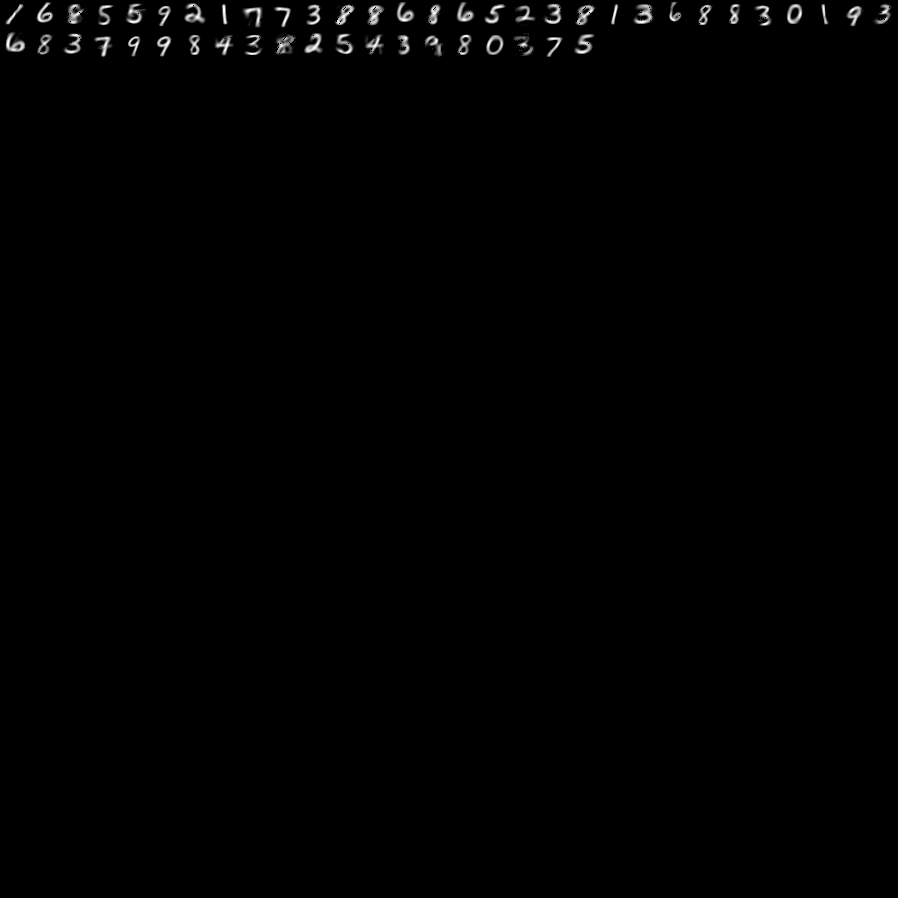

In [26]:
Image.open('/home/adrian/code/sideprojects/recons_9.png')

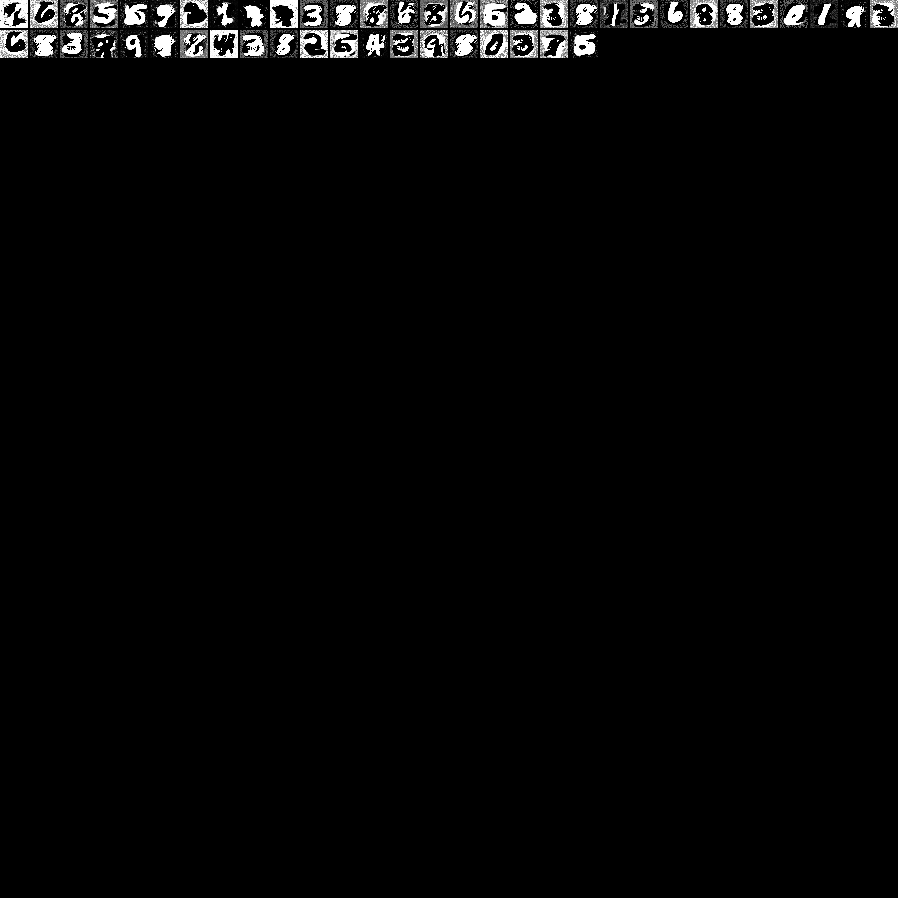

In [27]:
Image.open('/home/adrian/code/sideprojects/samples_9.png')

References:  
http://arxiv.org/pdf/1508.06585.pdf  
http://arxiv.org/pdf/1511.02841.pdf  
https://github.com/galinngeorgiev/ACE